# Singapore Resale Flat Prices Analysis (2017-2024)


In [101]:
# Standard libraries
import os
import zipfile
from datetime import datetime

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Preprocessing and model selection
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Installation and Setup

In [48]:
!kaggle datasets download -d darrylljk/singapore-hdb-resale-flat-prices-2017-2024

Dataset URL: https://www.kaggle.com/datasets/darrylljk/singapore-hdb-resale-flat-prices-2017-2024
License(s): other
 87%|█████████████████████████████████     | 2.00M/2.30M [00:00<00:00, 2.77MB/s]
100%|██████████████████████████████████████| 2.30M/2.30M [00:00<00:00, 2.77MB/s]


In [49]:
def unzip_file(zip_file):

    extract_to = os.path.dirname(os.path.abspath(zip_file))
    
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    os.remove(zip_file)
    
unzip_file("singapore-hdb-resale-flat-prices-2017-2024.zip")

In [50]:
data = pd.read_csv("sg-resale-flat-prices-2017-onwards.csv")
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


## Data Exploration and Cleaning



In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181262 entries, 0 to 181261
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                181262 non-null  object 
 1   town                 181262 non-null  object 
 2   flat_type            181262 non-null  object 
 3   block                181262 non-null  object 
 4   street_name          181262 non-null  object 
 5   storey_range         181262 non-null  object 
 6   floor_area_sqm       181262 non-null  float64
 7   flat_model           181262 non-null  object 
 8   lease_commence_date  181262 non-null  int64  
 9   remaining_lease      181262 non-null  object 
 10  resale_price         181262 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 15.2+ MB


In [52]:
# Check for missing values
data.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

In [53]:
# Convert 'month' to datetime format (year-month)
data['month'] = pd.to_datetime(data['month'], format='%Y-%m')

# Extract year and month
data['year'] = data['month'].dt.year
data['month_only'] = data['month'].dt.month

# Extract numerical representation of 'remaining_lease'
data['remaining_lease_years'] = data['remaining_lease'].apply(lambda x: int(x.split()[0]))

# Display the first few rows of the dataframe
data.head()


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_only,remaining_lease_years
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,61
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,60
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,62
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,62
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,62


In [54]:
# Check for duplicates
data[data.duplicated(keep=False)]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_only,remaining_lease_years
224,2017-01-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0,2017,1,57
243,2017-01-01,BUKIT MERAH,4 ROOM,106,HENDERSON CRES,07 TO 09,81.0,Improved,1975,57 years,470000.0,2017,1,57
304,2017-01-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0,2017,1,61
305,2017-01-01,CENTRAL AREA,3 ROOM,271,QUEEN ST,16 TO 18,68.0,Improved,1979,61 years 02 months,470000.0,2017,1,61
505,2017-01-01,JURONG EAST,4 ROOM,265,TOH GUAN RD,04 TO 06,101.0,Model A,1998,80 years 09 months,470000.0,2017,1,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178710,2024-05-01,BUKIT BATOK,4 ROOM,445A,BT BATOK WEST AVE 8,16 TO 18,92.0,Model A,2019,93 years 09 months,650000.0,2024,5,93
178742,2024-05-01,BUKIT BATOK,5 ROOM,461B,BT BATOK WEST AVE 8,04 TO 06,114.0,Improved,2019,94 years 05 months,735000.0,2024,5,94
178750,2024-05-01,BUKIT BATOK,5 ROOM,461B,BT BATOK WEST AVE 8,04 TO 06,114.0,Improved,2019,94 years 05 months,735000.0,2024,5,94
180186,2024-05-01,SENGKANG,5 ROOM,430D,FERNVALE LINK,19 TO 21,112.0,Improved,2015,90 years 01 month,770000.0,2024,5,90


In [55]:
# Drop duplicate rows and reset index
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [56]:
# Export cleaned data for Tableau
data.to_csv('cleaned_data.csv', index=False)

## Exploratory Data Analysis (EDA)


In [57]:
data = pd.read_csv("cleaned_data.csv")
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_only,remaining_lease_years
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,61
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,60
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,62
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,62
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,62


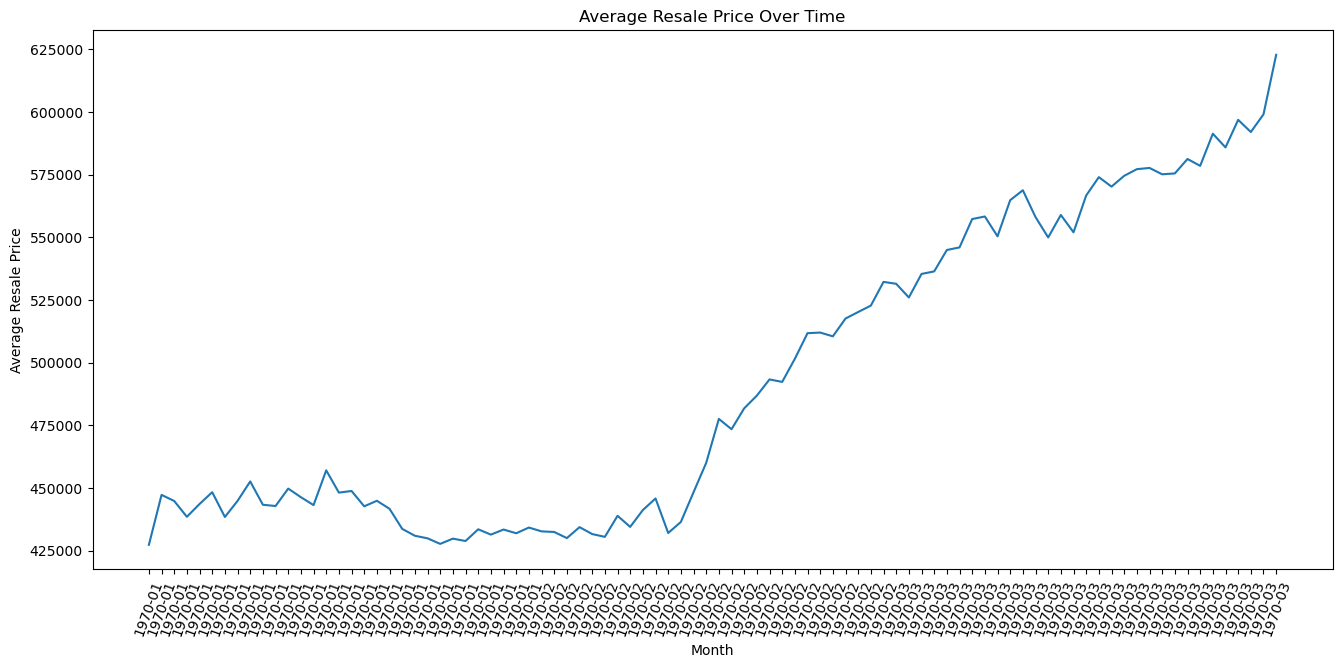

In [58]:
# Analyze trends over time
plt.figure(figsize=(16, 7))
sns.lineplot(data=data, x='month', y='resale_price', errorbar=None)
plt.title('Average Resale Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Resale Price')
plt.xticks(rotation=70) 

# Format x-axis to show year and month only
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

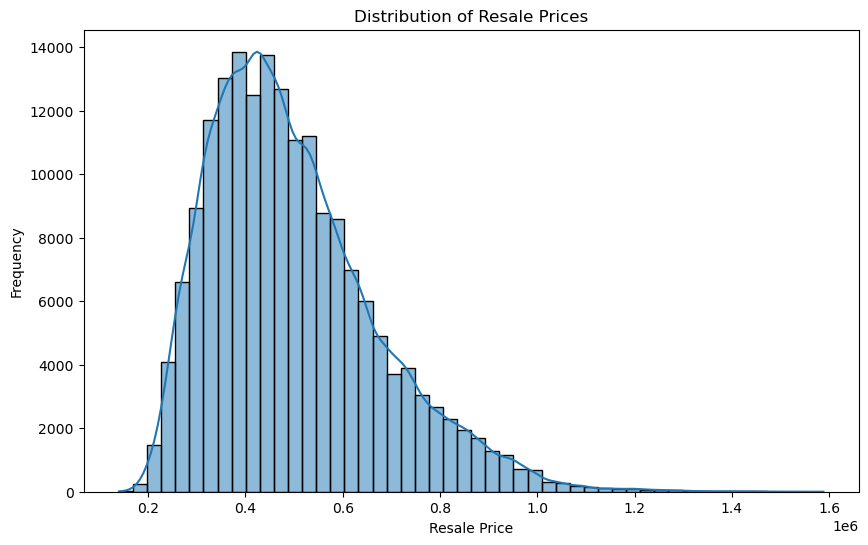

In [59]:
# Distribution of resale prices
plt.figure(figsize=(10, 6))
sns.histplot(data['resale_price'], bins=50, kde=True)
plt.title('Distribution of Resale Prices')
plt.xlabel('Resale Price')
plt.ylabel('Frequency')
plt.show()

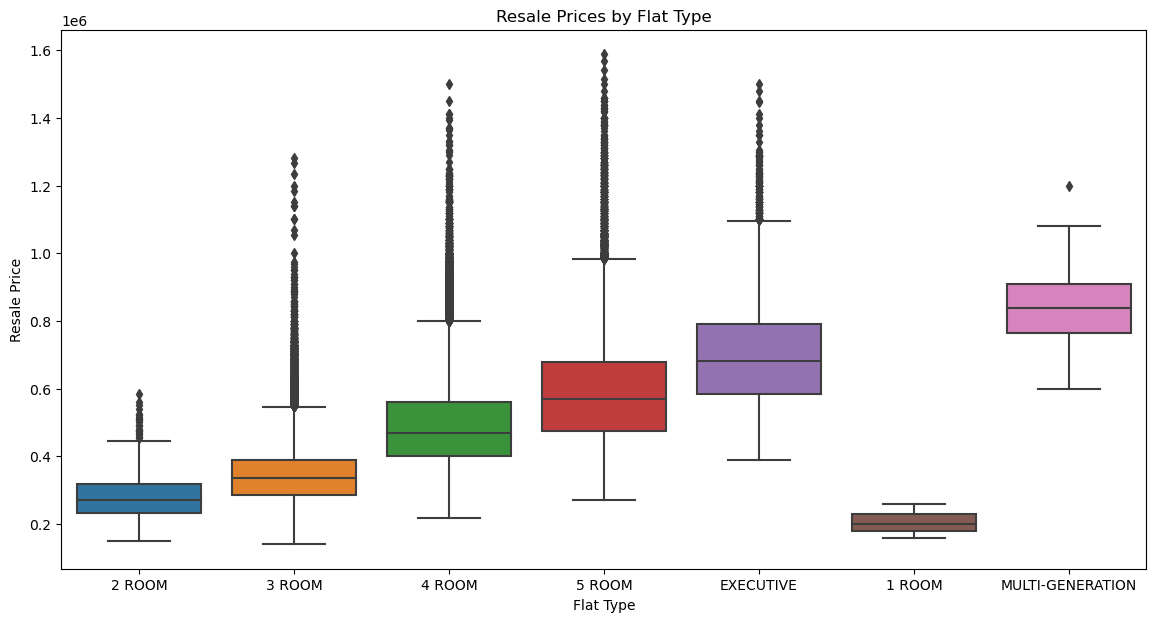

In [60]:
# Resale prices by flat type
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='flat_type', y='resale_price')
plt.title('Resale Prices by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price')
plt.show()

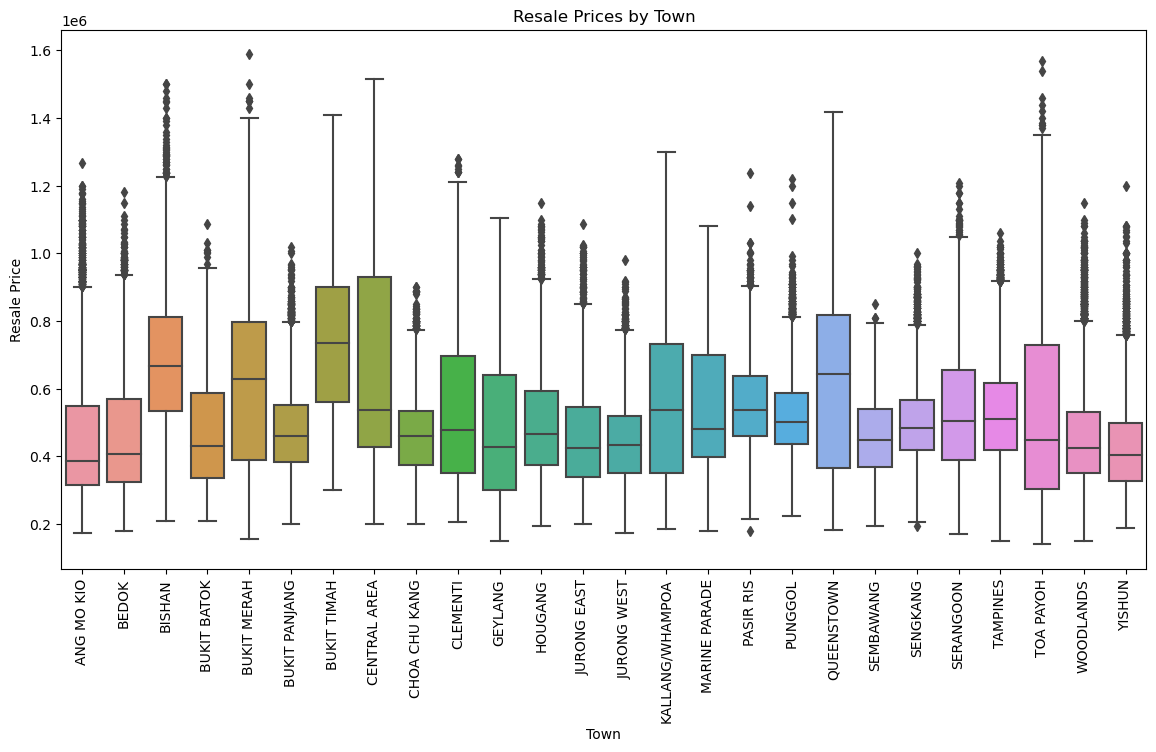

In [61]:
# Resale prices by town
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, x='town', y='resale_price')
plt.title('Resale Prices by Town')
plt.xlabel('Town')
plt.ylabel('Resale Price')
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing


In [62]:
# Create additional features
data['flat_age'] = data['year'] - data['lease_commence_date']

# Calculate average floor price per town
avg_price_per_town = data.groupby('town')['resale_price'].mean().reset_index()
avg_price_per_town.columns = ['town', 'avg_resale_price']
data = data.merge(avg_price_per_town, on='town', how='left')

# Display the first few rows of the dataframe with new features
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_only,remaining_lease_years,flat_age,avg_resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,61,38,454931.114702
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,60,39,454931.114702
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,62,37,454931.114702
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,62,37,454931.114702
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,62,37,454931.114702


In [78]:
# Display the unique values in the 'flat_type' and 'storey_range' columns and sort them
flat_type = sorted(data['flat_type'].unique())
storey_ranges = sorted(data['storey_range'].unique())

display(flat_type)
print()
display(storey_ranges)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0]

In [63]:
# Initialize the encoder with the specified order for flat_type
flat_type_enc = OrdinalEncoder(categories=[flat_type])
data['flat_type'] = flat_type_enc.fit_transform(data[['flat_type']])

# Initialize the encoder with the specified order for storey_ranges
storey_range_enc = OrdinalEncoder(categories=[storey_ranges])
data['storey_range'] = storey_range_enc.fit_transform(data[['storey_range']])

# Display the first few rows of the dataframe
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_only,remaining_lease_years,flat_age,avg_resale_price
0,2017-01-01,ANG MO KIO,1.0,406,ANG MO KIO AVE 10,3.0,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,61,38,454931.114702
1,2017-01-01,ANG MO KIO,2.0,108,ANG MO KIO AVE 4,0.0,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,60,39,454931.114702
2,2017-01-01,ANG MO KIO,2.0,602,ANG MO KIO AVE 5,0.0,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,62,37,454931.114702
3,2017-01-01,ANG MO KIO,2.0,465,ANG MO KIO AVE 10,1.0,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,62,37,454931.114702
4,2017-01-01,ANG MO KIO,2.0,601,ANG MO KIO AVE 5,0.0,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,62,37,454931.114702


In [64]:
data['flat_model'].unique()

array(['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
       'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
       'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen'],
      dtype=object)

In [65]:
# One-Hot Encoding for 'flat_model'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
encoded_flat_model = ohe.fit_transform(data[['flat_model']])
encoded_flat_model    

,flat_model_2-room,flat_model_3Gen,flat_model_Adjoined flat,flat_model_Apartment,flat_model_DBSS,flat_model_Improved,flat_model_Improved-Maisonette,flat_model_Maisonette,flat_model_Model A,flat_model_Model A-Maisonette,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180969,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180970,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Select features and target variable
features = ['flat_type', 'storey_range', 'floor_area_sqm', 'flat_age', 'remaining_lease_years', 'avg_resale_price']
X = pd.concat([data[features], encoded_flat_model], axis=1)
y = data['resale_price']

# Display the feature matrix
print("\nFeature matrix:")
X.head()


Feature matrix:


,flat_type,storey_range,floor_area_sqm,flat_age,remaining_lease_years,avg_resale_price,flat_model_2-room,flat_model_3Gen,flat_model_Adjoined flat,flat_model_Apartment,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,1.0,3.0,44.0,38,61,454931.114702,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,67.0,39,60,454931.114702,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,67.0,37,62,454931.114702,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,68.0,37,62,454931.114702,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,67.0,37,62,454931.114702,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

In [81]:
# Polynomial Regression
degree = 2
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
    ('linear_regression', LinearRegression())
])
poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = mse_poly ** 0.5
r2_poly = r2_score(y_test, y_pred_poly)

print(f"\nPolynomial Regression Model Performance (degree={degree}):")
print(f"MAE: {mae_poly}")
print(f"MSE: {mse_poly}")
print(f"RMSE: {rmse_poly}")
print(f"R²: {r2_poly}")


Polynomial Regression Model Performance (degree=2):
MAE: 70120.50911566548
MSE: 8364707019.656966
RMSE: 91458.77224004795
R²: 0.7237443399302111


In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Neural Network Model
nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
y_pred_nn = nn_model.predict(X_test).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = mse_nn ** 0.5
r2_nn = r2_score(y_test, y_pred_nn)

print(f"\nNeural Network Model Performance:")
print(f"MAE: {mae_nn}")
print(f"MSE: {mse_nn}")
print(f"RMSE: {rmse_nn}")
print(f"R²: {r2_nn}")


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step

Neural Network Model Performance:
MAE: 83574.96818284638
MSE: 11338969794.843891
RMSE: 106484.59886220115
R²: 0.6255153255428116


In [88]:
# Random Forest Regressor with Randomized Search
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=42)
rf_random_search.fit(X_train, y_train)
best_rf_model = rf_random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Model Performance:")
print(f"Best Parameters: {rf_random_search.best_params_}")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")


Random Forest Model Performance:
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
MAE: 35900.535666533615
MSE: 2605421546.729932
RMSE: 51043.33009052144
R²: 0.9139524615195136


In [89]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = mse_gb ** 0.5
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\nGradient Boosting Model Performance:")
print(f"Best Parameters: {gb_grid_search.best_params_}")
print(f"MAE: {mae_gb}")
print(f"MSE: {mse_gb}")
print(f"RMSE: {rmse_gb}")
print(f"R²: {r2_gb}")


Gradient Boosting Model Performance:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 48223.6165194804
MSE: 3988586211.4655333
RMSE: 63155.25482068403
R²: 0.8682715946889367


In [91]:
# Define the Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator
best_tree_model = grid_search.best_estimator_

# Make predictions
y_pred_tree = best_tree_model.predict(X_test)

# Evaluate model performance
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = mse_tree ** 0.5
r2_tree = r2_score(y_test, y_pred_tree)

print(f"\nDecision Tree Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mae_tree}")
print(f"MSE: {mse_tree}")
print(f"RMSE: {rmse_tree}")
print(f"R²: {r2_tree}")



Decision Tree Model Performance:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10}
MAE: 38713.01661466562
MSE: 3108936452.118388
RMSE: 55757.83758466955
R²: 0.8973232069363961


In [95]:
# Define the XGBoost Regressor model
xgb_model = XGBRegressor(random_state=42)

# Define hyperparameters to tune
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid Search
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

# Fit the model
xgb_grid_search.fit(X_train, y_train)

# Best estimator
best_xgb_model = xgb_grid_search.best_estimator_

# Make predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate model performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\nXGBoost Model Performance:")
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")


XGBoost Model Performance:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
MAE: 48072.691543013534
MSE: 3945042601.333911
RMSE: 62809.57412157729
R²: 0.8697096807725813


In [97]:
# XGBoost Model Performance
print(f"\nXGBoost Model Performance:")
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")

# Collect all metrics for comparison
results = {
    "Model": ["Polynomial Regression", "Neural Network", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"],
    "MAE": [mae_poly, mae_nn, mae_tree, mae_rf, mae_gb, mae_xgb],
    "MSE": [mse_poly, mse_nn, mse_tree, mse_rf, mse_gb, mse_xgb],
    "RMSE": [rmse_poly, rmse_nn, rmse_tree, rmse_rf, rmse_gb, rmse_xgb],
    "R²": [r2_poly, r2_nn, r2_tree, r2_rf, r2_gb, r2_xgb]
}

results_df = pd.DataFrame(results)

print("\nComparison of Model Performance:")
results_df


XGBoost Model Performance:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
MAE: 48072.691543013534
MSE: 3945042601.333911
RMSE: 62809.57412157729
R²: 0.8697096807725813

Comparison of Model Performance:


,Model,MAE,MSE,RMSE,R²
0,Polynomial Regression,69549.279263,8.406965e+09,91689.502548,0.722349
1,Neural Network,83574.968183,1.133897e+10,106484.598862,0.625515
2,Decision Tree,38713.016615,3.108936e+09,55757.837585,0.897323
3,Random Forest,35900.535667,2.605422e+09,51043.330091,0.913952
4,Gradient Boosting,48223.616519,3.988586e+09,63155.254821,0.868272
5,XGBoost,48072.691543,3.945043e+09,62809.574122,0.869710


## Feature importance

                              Feature  Importance
2                      floor_area_sqm    0.469822
5                    avg_resale_price    0.261395
4               remaining_lease_years    0.086370
3                            flat_age    0.084141
1                        storey_range    0.043242
0                           flat_type    0.023257
14                 flat_model_Model A    0.008424
10                    flat_model_DBSS    0.008420
19       flat_model_Premium Apartment    0.004015
11                flat_model_Improved    0.003585
18          flat_model_New Generation    0.001485
23                flat_model_Standard    0.001217
24                 flat_model_Terrace    0.001162
9                flat_model_Apartment    0.000816
13              flat_model_Maisonette    0.000665
22              flat_model_Simplified    0.000659
16                flat_model_Model A2    0.000254
8            flat_model_Adjoined flat    0.000230
15      flat_model_Model A-Maisonette    0.000214


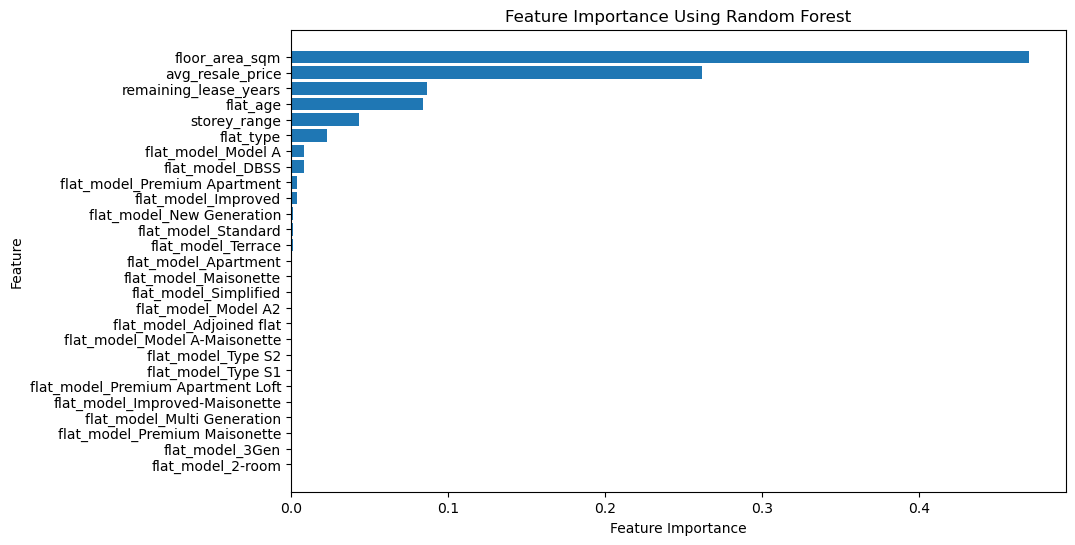

In [98]:
# Train the Random Forest model on the entire dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Using Random Forest')
plt.gca().invert_yaxis()
plt.show()


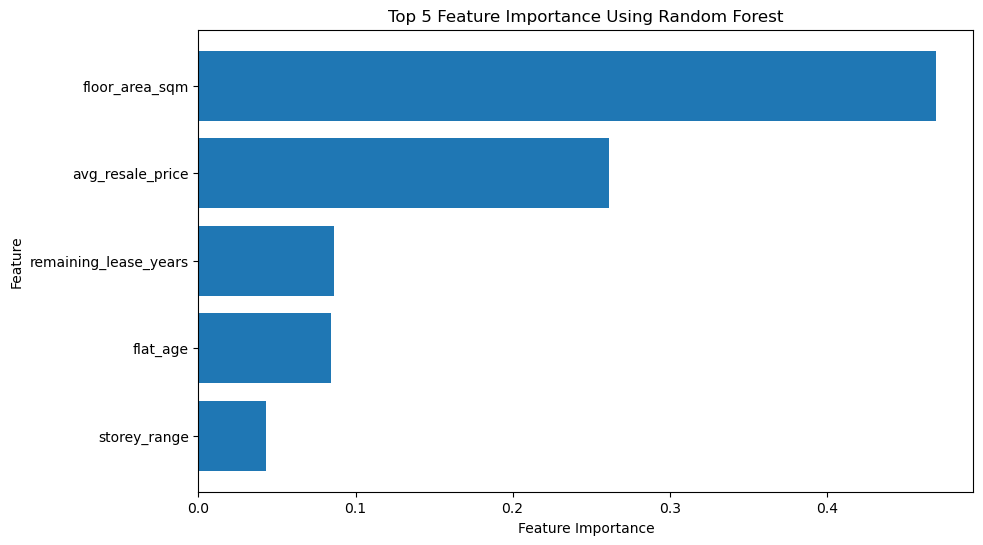

,Feature,Importance
2,floor_area_sqm,0.469822
5,avg_resale_price,0.261395
4,remaining_lease_years,0.086370
3,flat_age,0.084141
1,storey_range,0.043242


In [100]:
# Get top 5 most important features
top_5_features = feature_importance_df.head(5)

# Plot top 5 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importance Using Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Display top 5 feature importance DataFrame
top_5_features